In [10]:
import numpy as np
import random
from matplotlib import pyplot as plt

from one_particle import *
from qca import ChainQW, SimpleQW, get_omega, x_to_index

In [23]:
EPS = 1e-9

# Some checks

In [87]:
L = 100
theta = 2*np.pi*random.random()
alpha = np.cos(theta)
beta = np.sin(theta)
k = np.pi*random.random()/2
omega = get_omega(sign=1, k=k, alpha=alpha)
chi = np.pi*random.random()

In [88]:
xL = np.arange(-L, 3)
xR = np.arange(3, L)
o = np.array([1, 0])
T = np.exp(1j*omega)*(np.exp(-1j*chi)-1)/alpha/(np.exp(2j*k)-np.exp(-2j*k))
S = np.array([
    [1-T, -np.exp(2j*k)*T],
    [np.exp(-2j*k)*T, 1+T]
])

In [99]:
T0 = np.exp(2j*k) + np.exp(-2j*k)
Tchi = (np.exp(1j*(omega-chi)) + np.exp(-1j*omega))/alpha
S = np.array([
    [2*np.exp(2j*k)-Tchi, np.exp(2j*k)*(T0-Tchi)],
    [np.exp(-2j*k)*(Tchi-T0), Tchi-2*np.exp(-2j*k)]
])/(np.exp(2j*k) - np.exp(-2j*k))

In [100]:
ot = S @ o 
psi_plus_L = (1-(-1)**np.abs(xL)) * (o[0]*np.exp(-1j*k*xL)+o[1]*np.exp(1j*k*xL))
psi_plus_R = (1-(-1)**np.abs(xR)) * (ot[0]*np.exp(-1j*k*xR)+ot[1]*np.exp(1j*k*xR))
psi_plus = np.concatenate([psi_plus_L, psi_plus_R])
psi_minus = (np.exp(1j*omega)*shift(psi_plus, -1) - alpha*shift(psi_plus, 1))/(1j*beta)
psi_minus[x_to_index(x=0, L=L)] *= np.exp(-1j*chi)
psi = normalize(np.concatenate([psi_plus, psi_minus]))

In [101]:
for x in reversed(range(-L+10, L-10)):
    if x == 1:
        phase1 = np.exp(1j*chi)
    else:
        phase1 = 1
    eq1 = (alpha*psi_plus[x_to_index(x-2, L)]
        + 1j*beta*phase1*psi_minus[x_to_index(x-1, L)] 
        - np.exp(1j*omega)*psi_plus[x_to_index(x, L)])
    assert np.abs(eq1) < EPS, x

In [102]:
for x in range(-L+10, L-10):
    if x == 3:
        phase3 = Tchi
    else:
        phase3 = T0
    eq3 = (psi_plus[x_to_index(x, L)] 
           - phase3*psi_plus[x_to_index(x-2, L)] 
           + psi_plus[x_to_index(x-4, L)])
    assert np.abs(eq3) < EPS, x

In [104]:
for x in reversed(range(-L+10, L-10)):
    if x == -2:
        phase2 = np.exp(1j*chi)
    else:
        phase2 = 1
    eq2 = (1j*beta*psi_plus[x_to_index(x+1, L)]
        + alpha*phase2*psi_minus[x_to_index(x+2, L)] 
        - np.exp(1j*omega)*psi_minus[x_to_index(x, L)])

In [10]:
theta = 0
chi = 0

In [11]:
qw = SimpleQW(L=L, theta=theta, chi=chi, psi=psi)

In [12]:
qw.evolve()

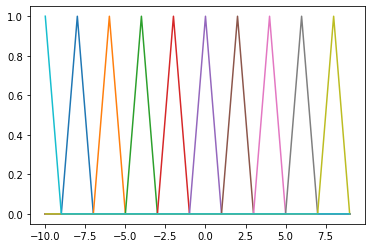

In [13]:
for _ in range(10):
    qw.plot_x()
    qw.evolve()

In [ ]:
qw = ChainQW(L=L, psi=psi, W=W)

Adding interaction:

Generalized free solutions:

In [32]:
k = random.randint(0, L)*dk
c = np.random.rand(4) + 1j*np.random.rand(4)
psi_plus = c[0]*plane_wave(L=L, k=k) + c[1]*plane_wave(L=L, k=k-np.pi)
psi_minus = c[2]*plane_wave(L=L, k=-k) - c[2]*plane_wave(L=L, k=np.pi-k)
psi = normalize(np.block([psi_plus, psi_minus]))

In [33]:
qw = ChainQW(psi=psi, blocks_w=blocks_w, L=L, V=V, d=d)
for n in range(L):
    qw.evolve()
    assert np.allclose(np.exp(2j*(n+1)*k)*psi, qw.psi)

Interacting solutions:

In [36]:
k = random.randint(0, L)*dk
c = np.random.rand(4) + 1j*np.random.rand(4)
psi_plus = c[0]*plane_wave(L=L, k=k) + c[1]*plane_wave(L=L, k=k-np.pi)
x = np.arange(-L, L)
psi_minus = np.exp(-1j*chi*np.heaviside(x, 1, where=x%2==0))*(c[2]*np.exp(1j*k*x)+c[3]*np.exp(1j*(k-np.pi)*x))
psi = normalize(np.block([psi_plus, psi_minus]))

In [37]:
qw = ChainQW(psi=psi, blocks_w=blocks_w, L=L, V=V, d=d)
for n in range(L):
    qw.evolve()
    assert np.allclose(np.exp(2j*(n+1)*k)*psi, qw.psi)

In [14]:

# initial state of QCA
psi_minus = localized_particle(L=L, x0=L/2, k=-k)
#
psi_plus = np.zeros(2*L)
#psi_minus = localized_particle(L=L, x0=-L/2, k=k)

# quantum walk




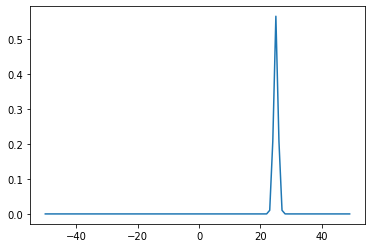

In [51]:
qw.plot_x()

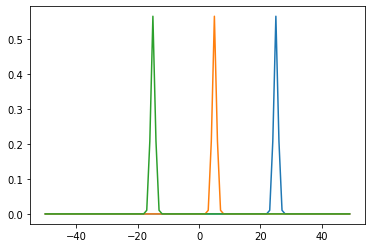

In [52]:
for _ in range(3):
    qw.plot_x()
    qw.evolve(10)

In [34]:
ps = []
for t in range(4*L):
    ps.append(qw.p_x(0))
    qw.evolve()

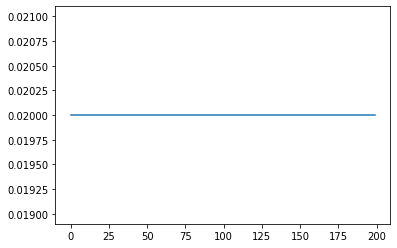

In [35]:
plt.plot(ps)

In [176]:
x = np.arange(-L, L)
chi = 0.1
omega = np.pi/L+chi
fns = [(np.exp(-1j*chi)-1)/(np.exp(-1j*omega)-np.exp(-1j*np.pi/L*n)) for n in np.arange(-L, L)]
f = sum([fns[i]*np.exp(1j*np.pi*(i-L)/L*x) for i in np.arange(2*L)])
f = normalize(f)

In [186]:
x = np.arange(-L, L)
chi = 0.1
omega = (np.pi+chi/2)/L
f = np.exp(1j*(omega*x-chi*np.heaviside(x, 1)))
#f = normalize(f)

In [187]:
f

array([-0.99875026+0.04997917j, -0.96399481-0.26592107j,
       -0.83187501-0.55496304j, -0.61573508-0.78795324j,
       -0.33740536-0.94135945j, -0.0249974 -0.99968752j,
        0.28993533-0.95704624j,  0.57558433-0.81774243j,
        0.80309879-0.5958459j ,  0.94949955-0.31376839j,
        0.99500417-0.09983342j,  0.97608058+0.21740908j,
        0.85857197+0.51269305j,  0.65434682+0.75619457j,
        0.38403206+0.92331976j,  0.07492971+0.99718882j,
       -0.24174061+0.97034091j, -0.53399491+0.84548769j,
       -0.77231524+0.63523946j, -0.93263104+0.36083146j])

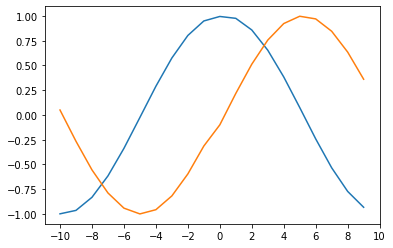

In [188]:
plt.plot(x, np.real(f))
plt.plot(x, np.imag(f))
plt.xticks([i for i in np.arange(-L, L+1) if i%2==0])
plt.show()

In [189]:
def phase(omega, chi, i):
    if i != L:
        return np.exp(1j*omega)
    else:
        return np.exp(1j*(omega-chi))

In [190]:
for i in range(2*L):
    print(f'{f[i]-phase(omega, chi, i)*f[(i-1)%(2*L)]:.6f}')

0.000000-0.000000j
0.000000+0.000000j
-0.000000+0.000000j
-0.000000+0.000000j
0.000000+0.000000j
0.000000+0.000000j
-0.000000+0.000000j
0.000000+0.000000j
0.000000+0.000000j
0.000000+0.000000j
0.000000+0.000000j
-0.000000+0.000000j
-0.000000+0.000000j
0.000000+0.000000j
0.000000-0.000000j
0.000000-0.000000j
-0.000000-0.000000j
0.000000+0.000000j
0.000000+0.000000j
0.000000+0.000000j


In [154]:
np.angle(a)

0.34428707323776453

In [156]:
np.pi*chi

0.3141592653589793

In [152]:
a = (f[L]-(0.143307-0.399664j))/f[L-1]

In [153]:
np.abs(a)

0.9999985989615854